In [1]:
import pickle
import matplotlib as plt
import os
from utils.basie_class import *
from scipy.stats import ttest_ind
import re
import pandas as pd
import Levenshtein as lvn

In [2]:
foldpath ='/Users/emiliedolne/Downloads/all'

In [3]:
# list of each group
ctrl=['ANDRU','BANCA', 'BLAJ', 'DUNPE','FARRO','HEWDE', 'HOWCH', 'HUGRO', 'JONJO', 'LADA', 'MACJA', 'RICJU', 'SELGI', 'STRNE', 'VANVE']
ad=['BOIOL', 'BROMA', 'DOLST', 'HARJO', 'HEIBE', 'HONJO', 'JACAN', 'MCDMA', 'TALRU', 'THOAN2', 'VANSI', 'WOOCH']
ivppa=['BLAAD', 'CHACH', 'CODJO', 'DISPA', 'HEWCO', 'JONGW', 'PETMI', 'THIJO']
print(len(ctrl))
print(len(ad))
print(len(ivppa))

15
12
8


In [4]:
# plot options
colorlist={}
colorlistflash={}

colorlist['ctrl']='b'
colorlist['ad']='r'
colorlist['ivppa']='g'
colorlistflash['ctrl']='aqua'
colorlistflash['ad']='mistyrose'
colorlistflash['ivppa']='lime'

## Trying a single patient

In [5]:
recordings=pd.read_csv('/Users/emiliedolne/Library/CloudStorage/OneDrive-ImperialCollegeLondon/PhD/Year 3/Smartter hear/py_bayesi/data/recordings.txt', sep='\t', engine='python').to_numpy()
sentences=pd.read_csv('/Users/emiliedolne/Library/CloudStorage/OneDrive-ImperialCollegeLondon/PhD/Year 3/Smartter hear/py_bayesi/data/sentences.txt', sep='\t').to_numpy()

In [6]:
df = pd.read_csv('/Users/emiliedolne/Downloads/all/BROMAoffice/20231207_112543/results.csv')
# print(df)

In [7]:
refwords=[]
choices=df['choice'].to_numpy()
for i in range(len(df['file'])):
    tmp=df['file'][i][0:7]
    if tmp in recordings:
        idx=np.where(recordings==(tmp))
    else:
        idx=np.where(recordings==(tmp+' '))
    refwords.append(sentences[idx[0][0]][idx[1]][0])
refwords=np.array(refwords)

print('choice \t correct')
print('------ \t -------')
[print(x,'\t',y) for x,y in zip(choices, refwords) if x!=y];

choice 	 correct
------ 	 -------
xxx 	 hot
word 	 oil
xxx 	 hen
xxx 	 cud
xxx 	 sum
tears 	 teal
safe 	 same
that 	 bat
done 	 dung
club 	 pub
xxxx 	 pill
pub 	 buck
xxxx 	 duck
cake 	 cape
gay 	 gale
book 	 hook
fag 	 fang
hat 	 pat
full 	 will
xxx 	 bed
mad 	 man


## Loading all patients

In [8]:
def load_group(group):
    listgroup=[]
    i=0
    for patientID in group:
        listgroup.append([])
        for fold in os.listdir(foldpath):
            if patientID in fold:
                listgroup[i].append(fold)
        if len(listgroup[i])==1:
            newfoldpath=os.path.join(foldpath, listgroup[i][0])
            listgroup[i]=[]
            for fold in os.listdir(newfoldpath):
                if patientID in fold:
                    listgroup[i].append(fold)
        i+=1
    return listgroup

In [9]:
# load organised list of people
listpatients={}

listpatients['ctrl']=load_group(ctrl)
listpatients['ad']=load_group(ad)
listpatients['ivppa']=load_group(ivppa)

### Load word vectors

In [10]:
def load_errors(room, group):
    # find the groups in that room
    listperroom=[]
    for i in group:
        for j in i:
            if room in j:
                listperroom.append(j)
                
    # load data from file
    ptntlist=[]  
    estimatelist=[]
    for ptnt in listperroom:
        ptntlist.append(ptnt[0:5])
        for path, subdirs, files in os.walk(os.path.join(foldpath, ptnt)):
            for name in files:
                if 'csv' in name:
#                     timinglist.append(path.split('/')[-1])
                    with open(os.path.join(path,name), 'rb') as f:
                        estimate=pd.read_csv(f)
                        estimatelist.append(estimate)
                
    metrics=[];
    for df in estimatelist:
        refwords=[]
        choices=df['choice'].to_numpy()
        for i in range(len(df['file'])):
            tmp=df['file'][i][0:7]
            if tmp in recordings:
                idx=np.where(recordings==(tmp))
            else:
                idx=np.where(recordings==(tmp+' '))
            refwords.append(sentences[idx[0][0]][idx[1]][0])
        
        refwords=np.array(refwords)
        wrongwords=[(x,y) for x,y in zip(choices, refwords) if x!=y];
        xcntr=0
        lowcntr=0
        highcntr=0
        for i in wrongwords:
            if isinstance(i[0], float) or i=='x' or 'xx' in i[0] or 'pancking' in i[0] or 'panicking' in i[0]:
                xcntr+=1
            else:
                lvndist=lvn.distance(i[0],i[1])
                if lvndist>0.5*len(i[1]):
                    highcntr+=1
                else:
                    lowcntr+=1
        metrics.append([xcntr, lowcntr, highcntr])
        
    return metrics

In [11]:
roomlist=['anechoic','office', 'lobby', 'lectureroom']
groups=['ctrl','ad', 'ivppa']
errortypes=['x','low', 'high']

metrics_data={}

for room in roomlist:
    metrics_data[room]={}
    for group in groups:
        metrics_data[room][group]={}
        metrics=load_errors(room, listpatients[group])
        for i, error in enumerate(errortypes):
            metrics_data[room][group][error]=[tmp[i] for tmp in metrics]


In [12]:
print((metrics_data['lobby']['ivppa']['high']))

[11, 9, 6, 6, 9, 5, 5, 14]


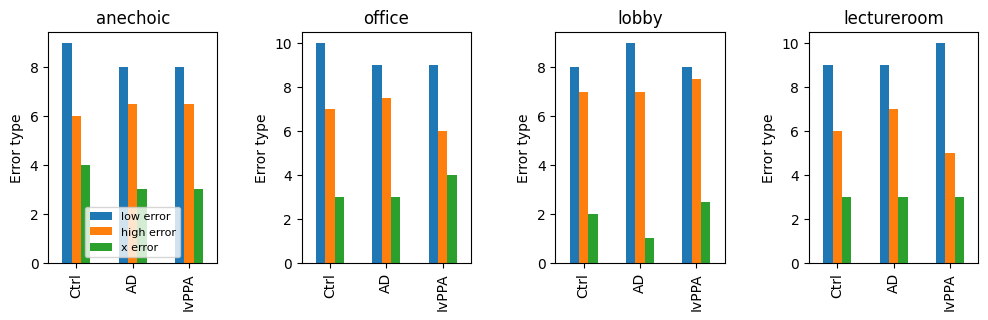

In [13]:
fig=plt.figure(figsize=(12,3))

gs = fig.add_gridspec(1,4, wspace=0.5)
ax=[]
ax.append(fig.add_subplot(gs[0, 0]))
ax.append(fig.add_subplot(gs[0, 1]))
ax.append(fig.add_subplot(gs[0, 2]))
ax.append(fig.add_subplot(gs[0, 3]))
for i, room in enumerate(roomlist):
    plt.sca(ax[i])
    plotdata = pd.DataFrame({
        "low error":[np.median(metrics_data[room]['ctrl']['low']),np.median(metrics_data[room]['ad']['low']),np.median(metrics_data[room]['ivppa']['low'])],
        "high error":[np.median(metrics_data[room]['ctrl']['high']),np.median(metrics_data[room]['ad']['high']),np.median(metrics_data[room]['ivppa']['high'])],
        "x error":[np.median(metrics_data[room]['ctrl']['x']),np.median(metrics_data[room]['ad']['x']),np.median(metrics_data[room]['ivppa']['x'])],},
        index=["Ctrl", "AD", "IvPPA"])
    plotdata.plot(kind='bar', stacked=False, ax=ax[i])
    plt.title(room)
    plt.ylabel("Error type")
    if i>0:
        ax[i].get_legend().remove()
ax[0].legend(loc='lower center', fontsize=8)


In [14]:
lvn.distance('but', 'buck')

2